# 引入需要的套件

In [1]:
import pandas as pd
import numpy as np
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F

import transformers
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification

from sklearn.model_selection import train_test_split
from collections import defaultdict

RANDOM_SEED = 42

# 載入資料，取整個資料長度的1/10約35000筆

In [2]:
original_df = pd.read_csv('reviews.csv')
fullsize = len(original_df)
datasize = int(fullsize * 0.1)
df = original_df.sample(datasize)
print(df.shape)
notseen_df = pd.concat([original_df, df]).drop_duplicates(keep=False) # 取出沒用過的資料，佔90%
print(notseen_df.shape)

(34165, 3)
(307493, 3)


# 定義模型參數來源以及設定檔

In [3]:
PRE_TRAINED_MODEL_NAME = 'distilbert-base-multilingual-cased'
tokenizer = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# 超參數設定

In [4]:
MAX_LEN = 512
EPOCHS = 2
BATCH_SIZE = 8
LR = 2e-5

# 建立資料集類別

In [5]:
class GPReviewDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.reviews)
  
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

# 資料拆分為訓練、驗證、測試集，90%，5%，5%

In [6]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

# 建立資料產生器

In [7]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(), # 將整個pandas df變成字串為主的numpy array
        targets=df.label.to_numpy(),   # 將整個pandas df變成字串為主的numpy array
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=BATCH_SIZE,
        num_workers=4
    )

In [8]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [9]:
distilbert_config = DistilBertConfig 
distilbert_class =  DistilBertForSequenceClassification
    
config = distilbert_config.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels = 2)
model = distilbert_class.from_pretrained(PRE_TRAINED_MODEL_NAME, config=config)

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier.weight', 'pre_cla

In [10]:
'''
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)
'''

'\nclass SentimentClassifier(nn.Module):\n\n    def __init__(self, n_classes):\n        super(SentimentClassifier, self).__init__()\n        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)\n        self.drop = nn.Dropout(p=0.3)\n        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)\n  \n    def forward(self, input_ids, attention_mask):\n        _, pooled_output = self.bert(\n        input_ids=input_ids,\n        attention_mask=attention_mask\n        )\n        output = self.drop(pooled_output)\n        return self.out(output)\n'

In [11]:
'''
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names = ['negative', 'positive']
model = SentimentClassifier(len(class_names))
model = model.to(device)
'''

class_names = ['negative', 'positive']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() > 1:
    print(torch.cuda.device_count(), " GPUs")
    model = nn.DataParallel(model)
else:
    print("Single GPU")


Single GPU


In [12]:
model = model.to(device)

In [13]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [14]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 512])
torch.Size([8, 512])


In [15]:
output = model(input_ids, attention_mask)
output = output[0]

In [16]:
F.softmax(output, dim=1)

tensor([[0.4988, 0.5012],
        [0.4878, 0.5122],
        [0.4884, 0.5116],
        [0.5026, 0.4974],
        [0.4970, 0.5030],
        [0.4936, 0.5064],
        [0.4879, 0.5121],
        [0.5011, 0.4989]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [17]:
optimizer = AdamW(model.parameters(), lr=LR, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [18]:
def train_epoch(
    model, 
    data_loader, 
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    n_examples
    ):
    model = model.train()

    losses = []
    correct_predictions = 0
  
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        outputs = outputs[0]

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [19]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            outputs = outputs[0]
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [20]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.19104203258124525 accuracy 0.9426629374268245
Val   loss 0.17436663421723886 accuracy 0.955503512880562

Epoch 2/2
----------
Train loss 0.11768155862091731 accuracy 0.9691362039807466
Val   loss 0.20028096642867427 accuracy 0.9566744730679156

CPU times: user 14min 3s, sys: 6min 43s, total: 20min 47s
Wall time: 20min 51s


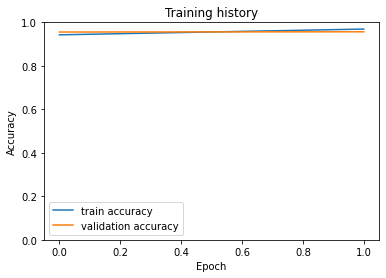

In [21]:
import matplotlib.pyplot as plt

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
'''
class_names = ['negative', 'positive']
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)


model = model.to(device)
'''

In [22]:
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

test_acc.item()

0.9625511995318901

In [23]:
def get_predictions(model, data_loader):
    model = model.eval()
  
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
            attention_mask=attention_mask
            )
            outputs = outputs[0]
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [24]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.95      0.96      0.96       721
    positive       0.97      0.96      0.97       988

    accuracy                           0.96      1709
   macro avg       0.96      0.96      0.96      1709
weighted avg       0.96      0.96      0.96      1709



In [145]:
test_data = notseen_df.sample(1)
review_text = test_data.iloc[0].content
review_label= test_data.iloc[0].label
hotel_name = test_data.iloc[0].hotel_name

encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  truncation=True,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
output = output[0]
_, prediction = torch.max(output, dim=1)

print(output)
print(F.softmax(output, dim=1))
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')
print(f'prediction : {prediction.item()}')
print(f'groundtruth : {review_label}')
print(f'hotel : {hotel_name}')

tensor([[-3.4505,  4.7439]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[2.7612e-04, 9.9972e-01]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Review text: 服務很好很貼心
Sentiment  : positive
prediction : 1
groundtruth : 1
hotel : 高雄國賓大飯店265


In [108]:
model.save_pretrained("mydistilbert")

In [ ]:
my_loader = create_data_loader(df.sample(500), tokenizer, MAX_LEN, BATCH_SIZE)
testdata = next(iter(my_loader))
targets = testdata["targets"].to(device)
input_ids = testdata['input_ids'].to(device)
attention_mask = testdata['attention_mask'].to(device)
outputs = model(input_ids, attention_mask)
loss = loss_fn(outputs, targets)